<a href="https://colab.research.google.com/github/leminhviett/Label-Video/blob/master/Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path = '/content/drive/My Drive/data/'

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import cv2

from google.colab.patches import cv2_imshow

In [0]:

def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)
    return graph

def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

def read_tensor_from_video_file(numpy_data, input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
    tensor = tf.convert_to_tensor(numpy_data, dtype = tf.float32)
    dims_expander = tf.expand_dims(tensor, 0)
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.compat.v1.Session()
    result = sess.run(normalized)

    return result

    

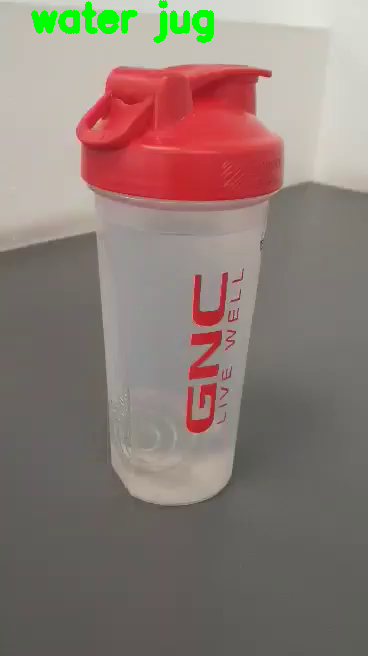

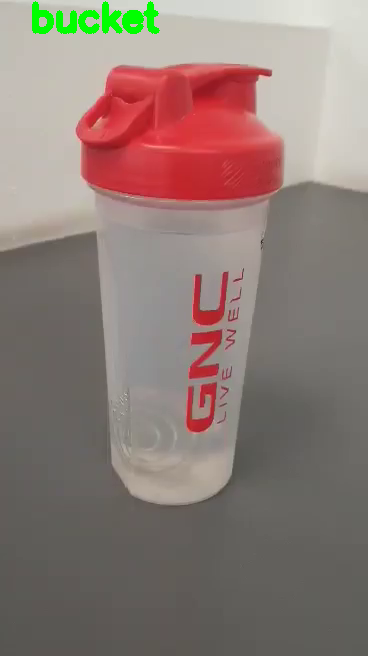

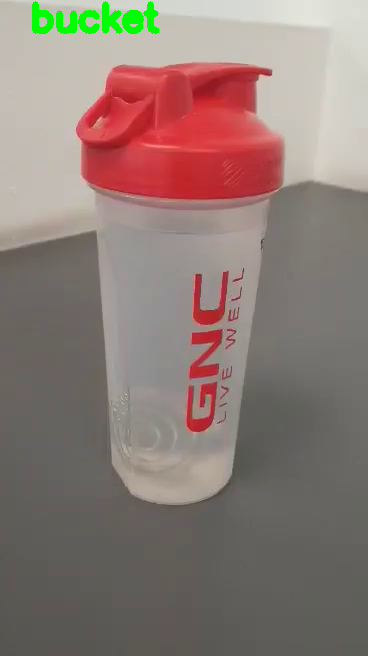

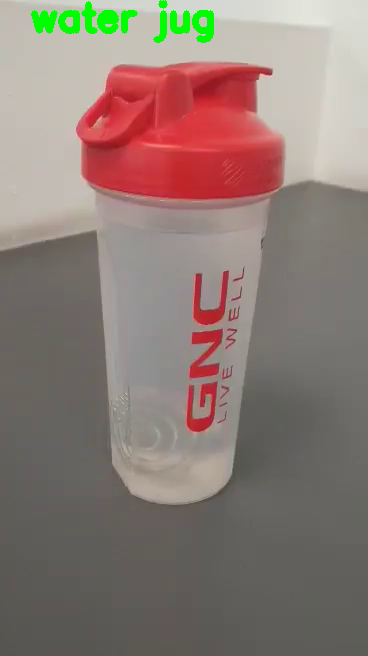

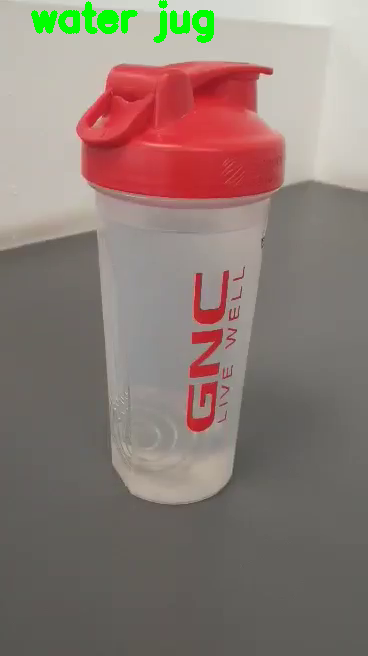

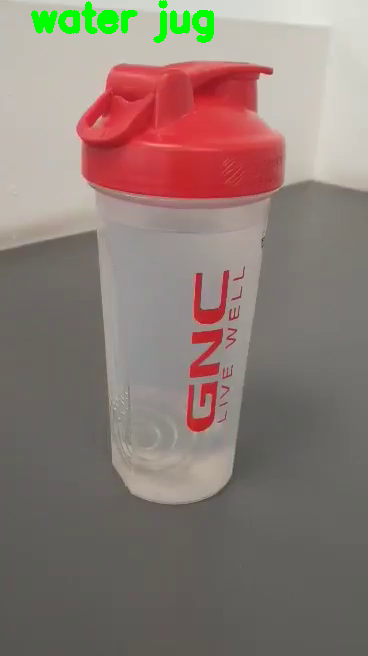

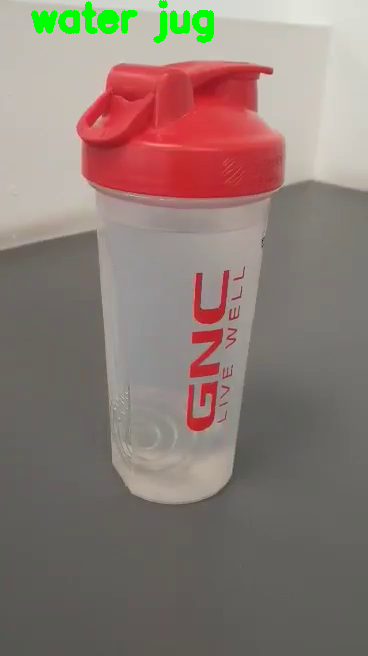

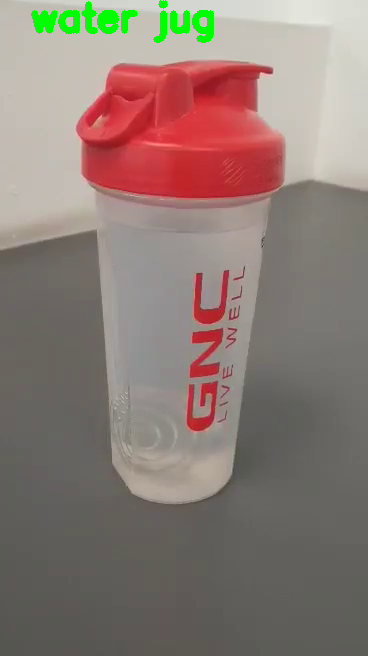

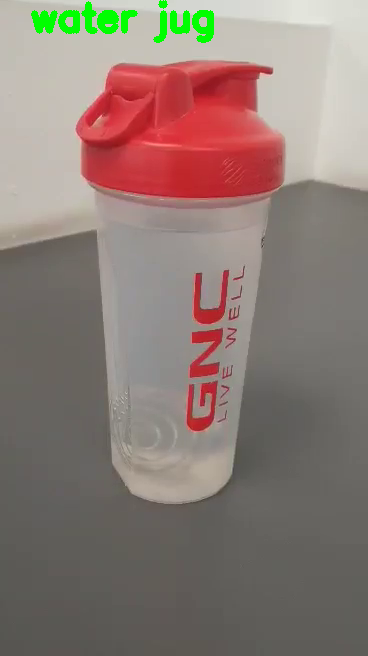

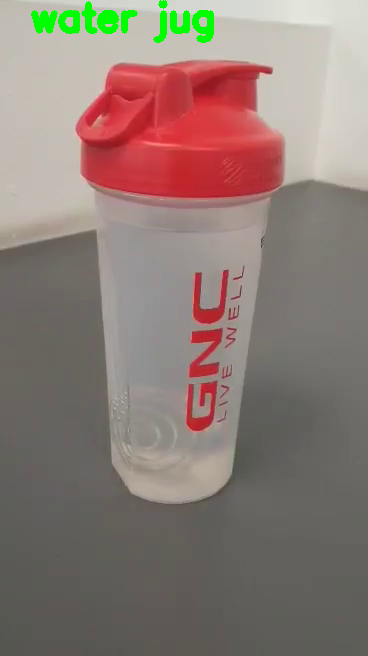

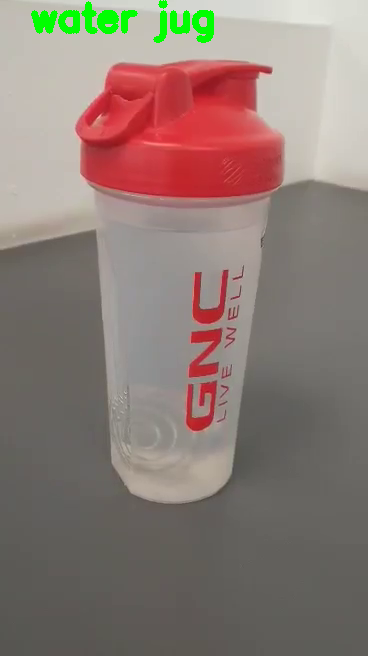

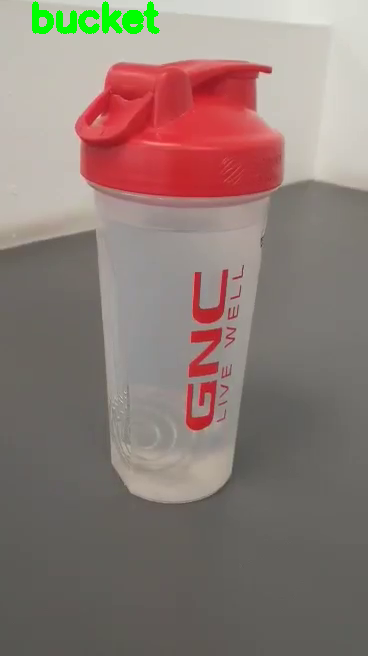

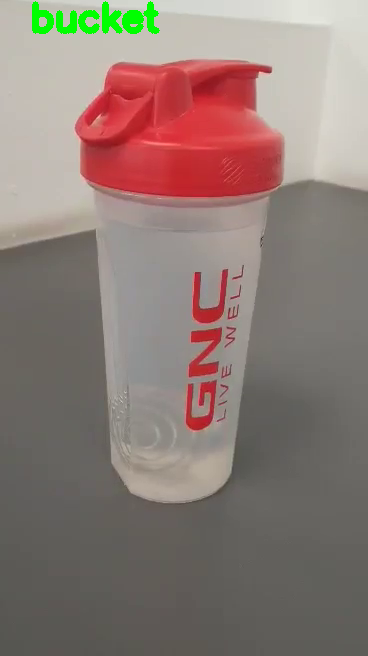

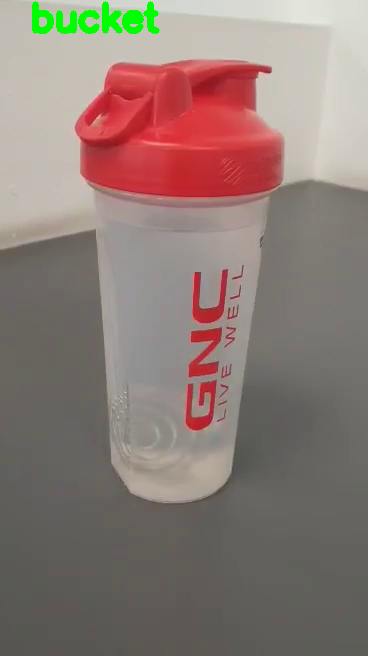

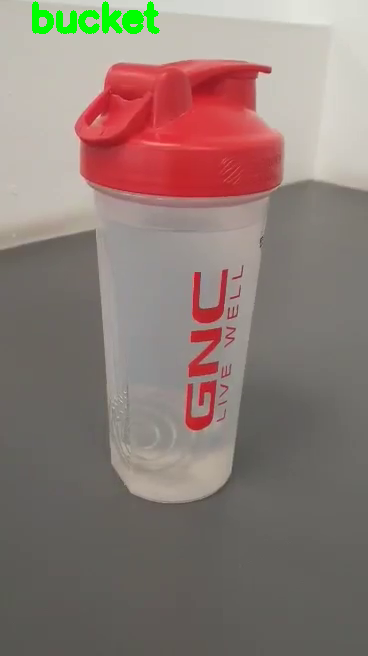

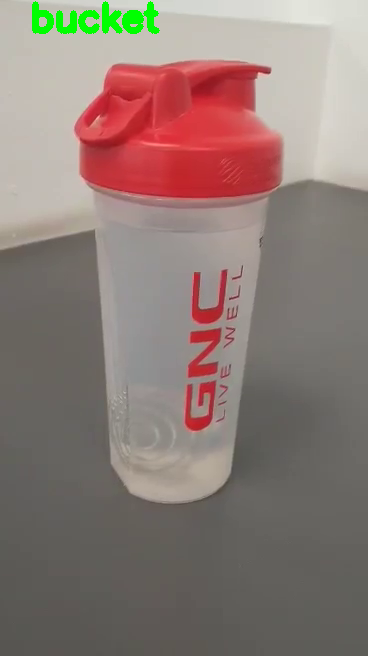

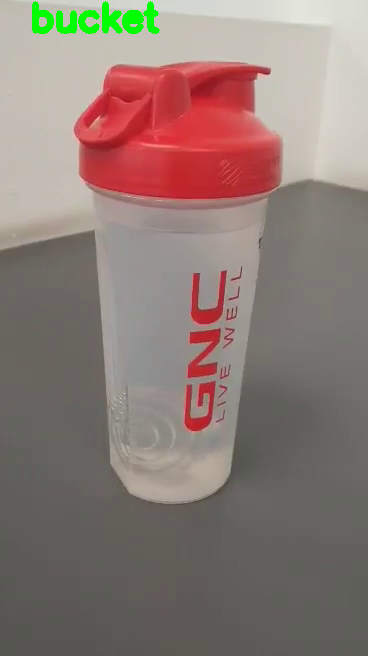

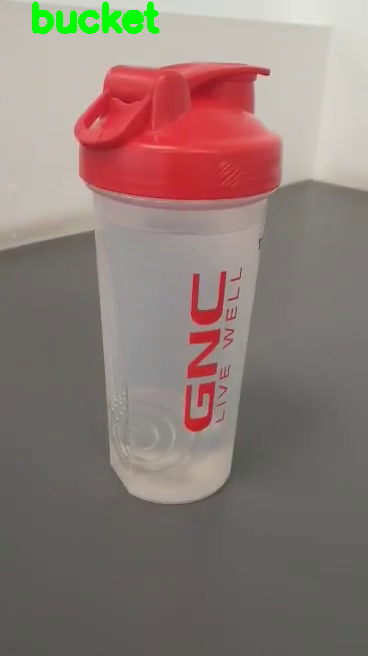

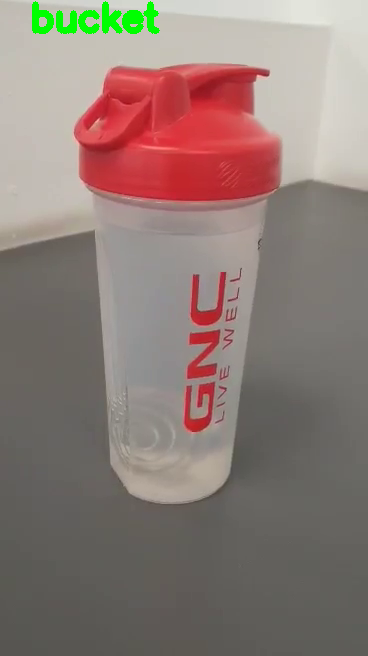

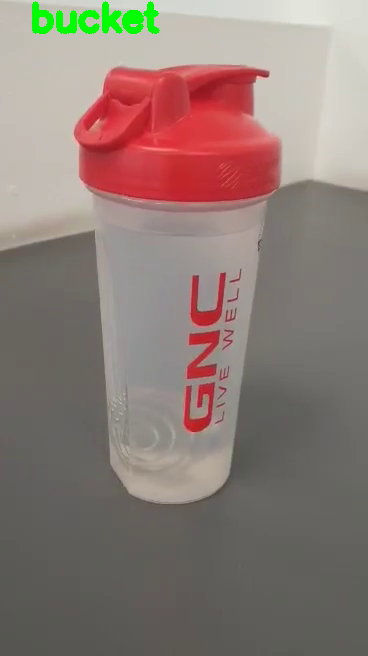

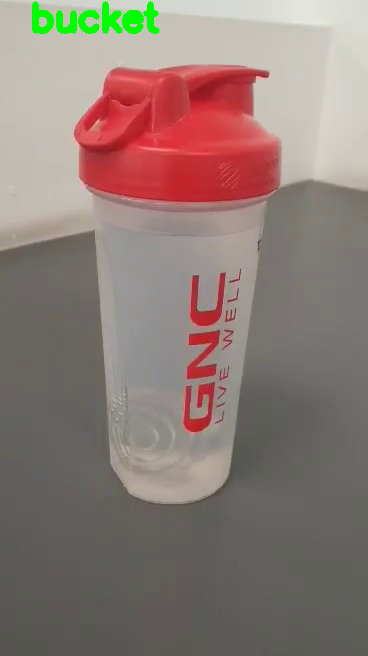

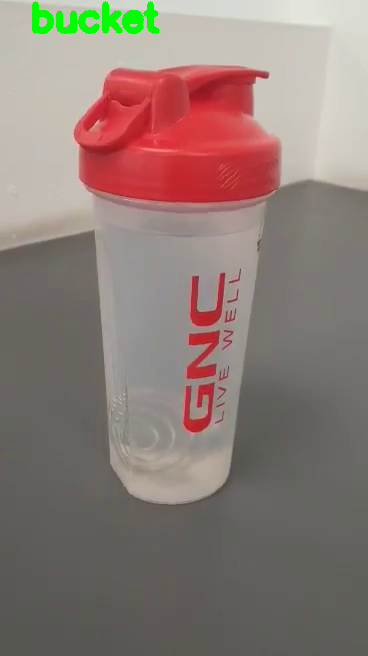

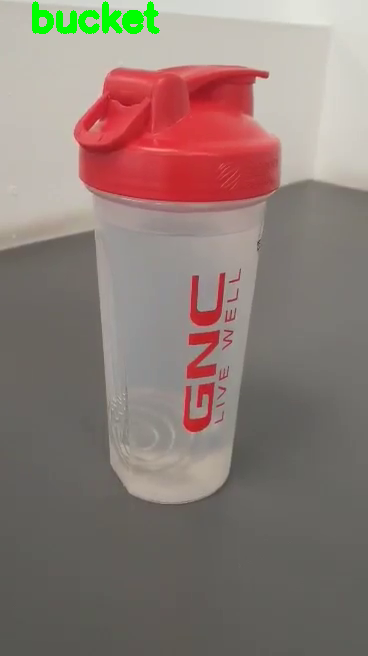

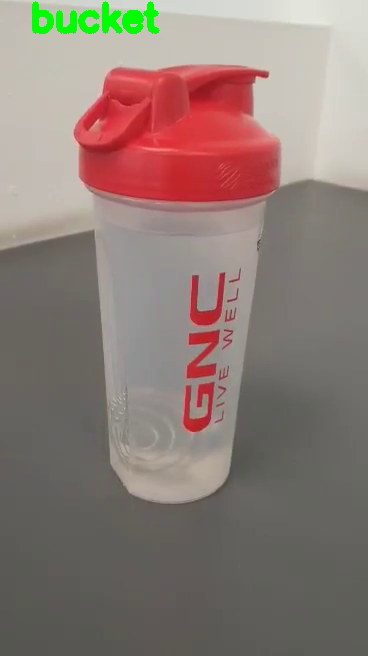

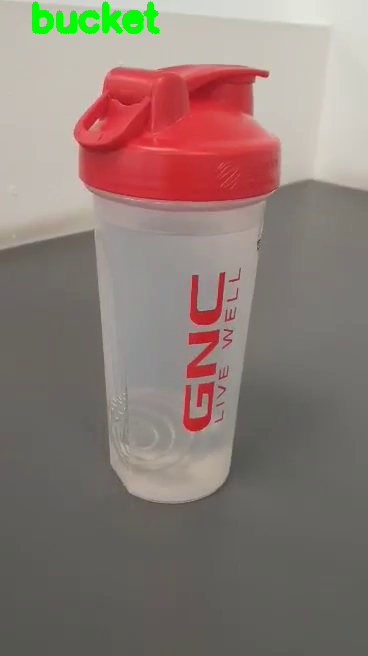

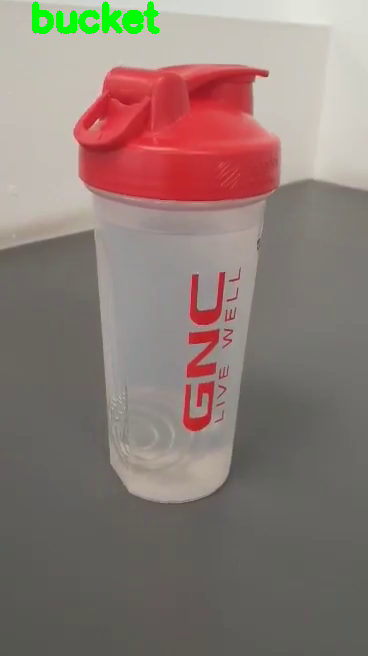

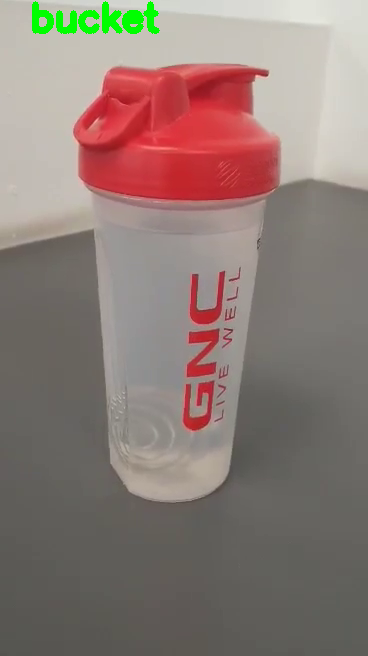

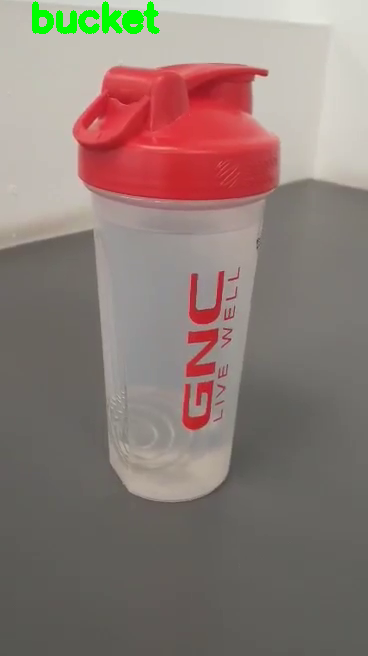

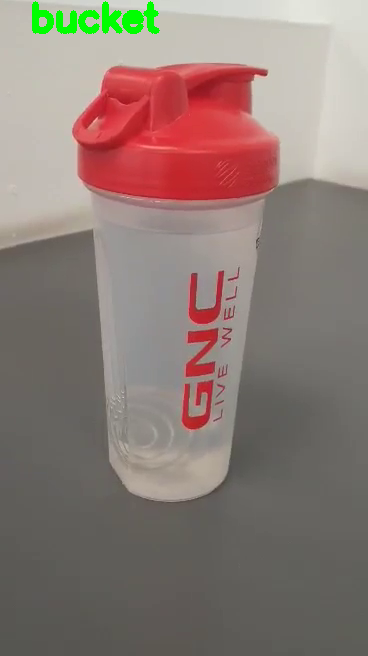

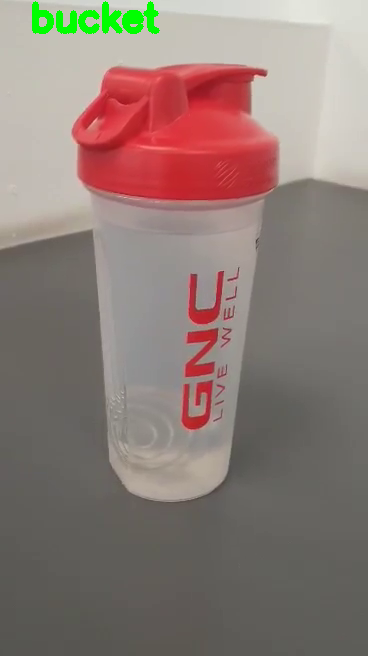

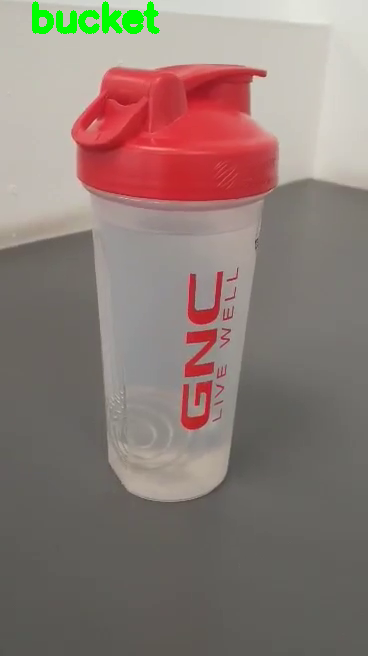

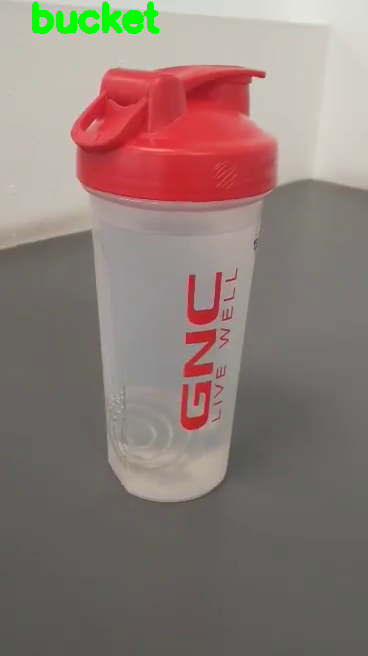

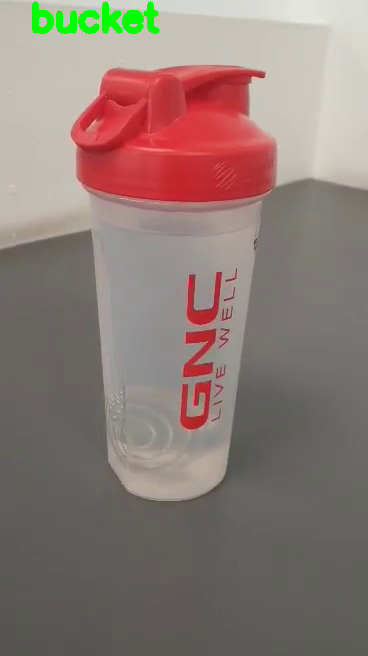

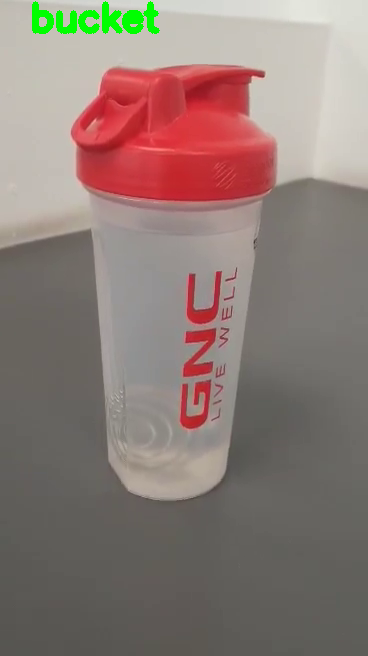

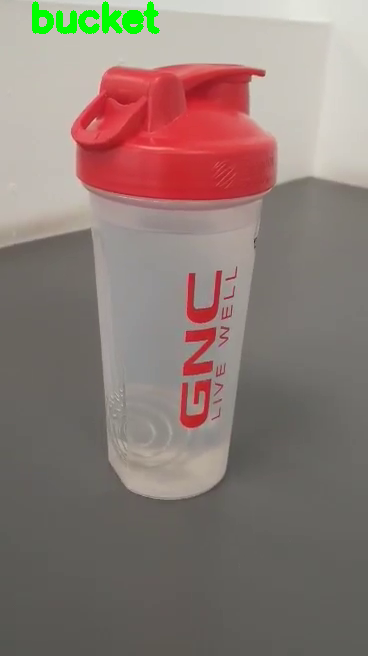

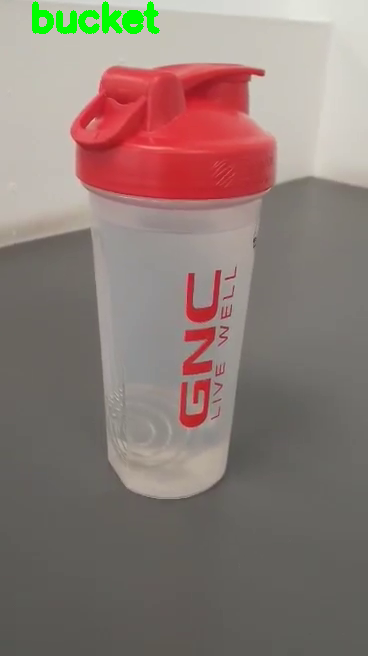

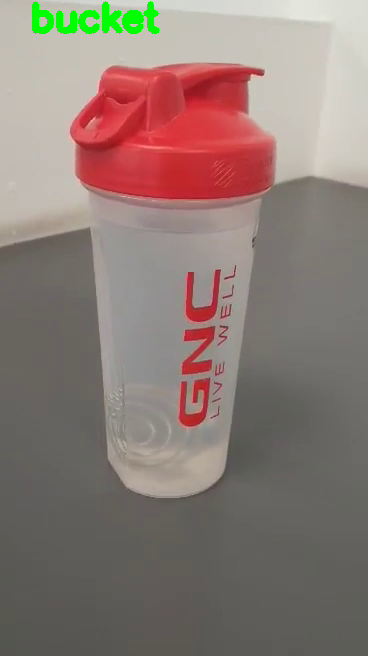

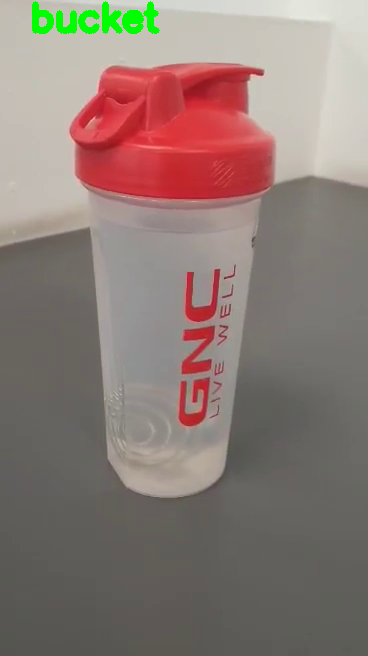

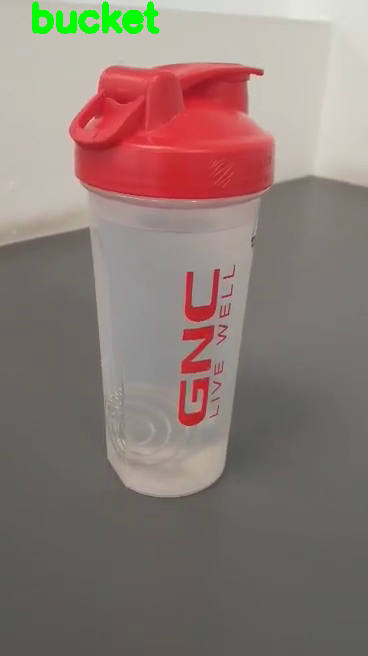

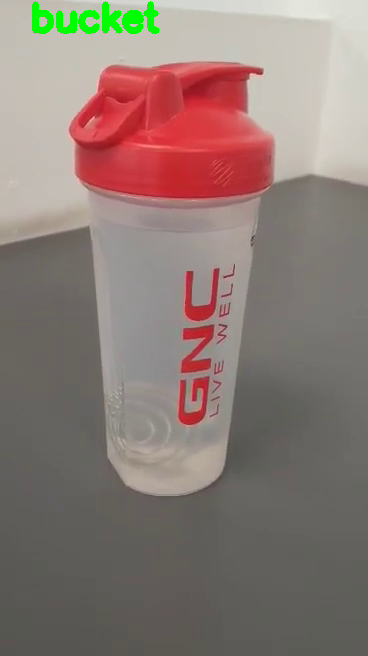

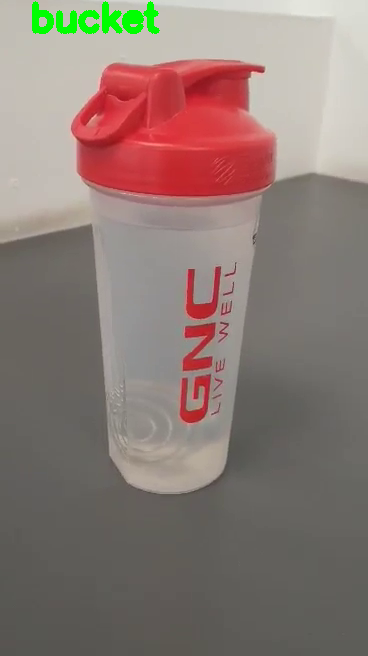

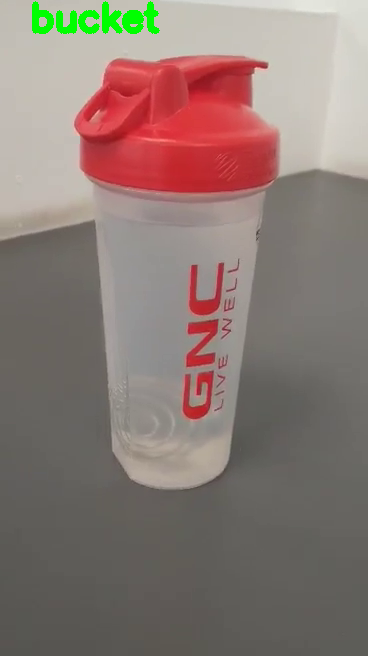

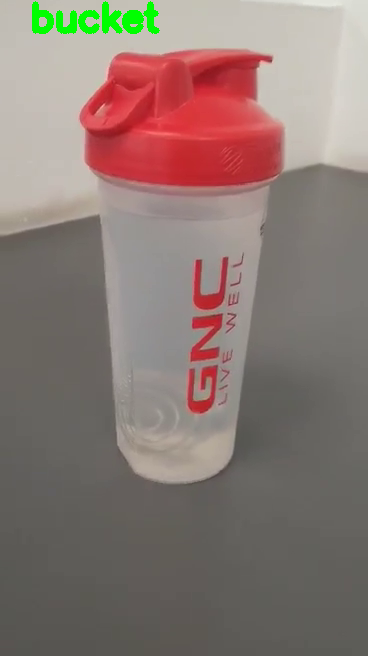

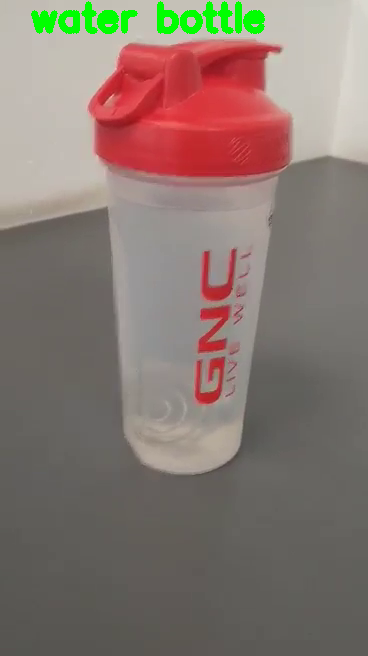

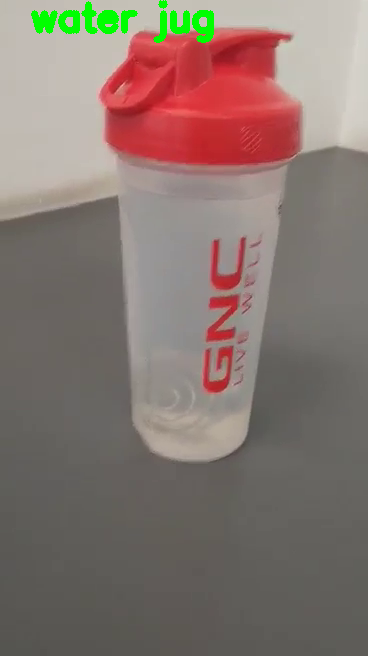

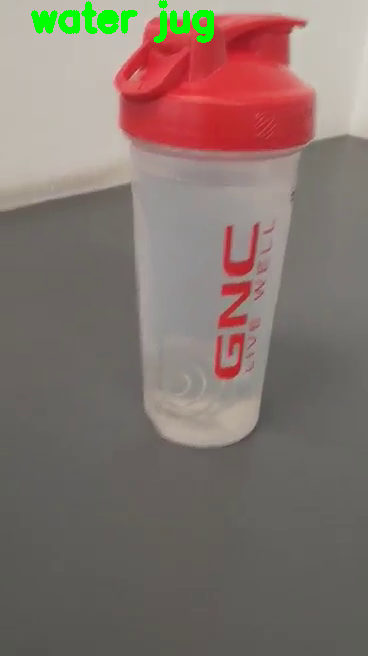

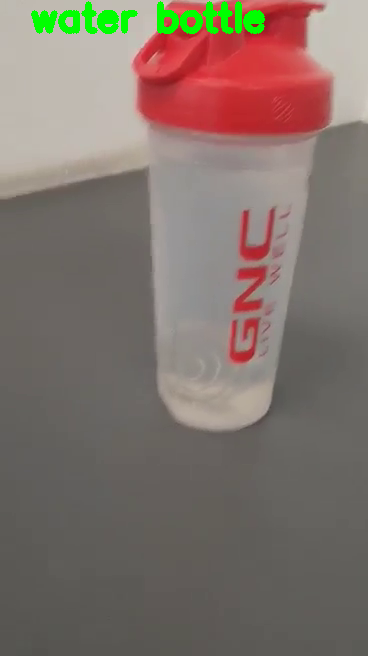

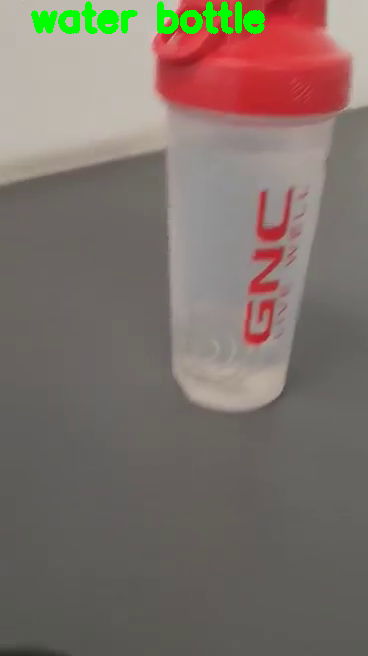

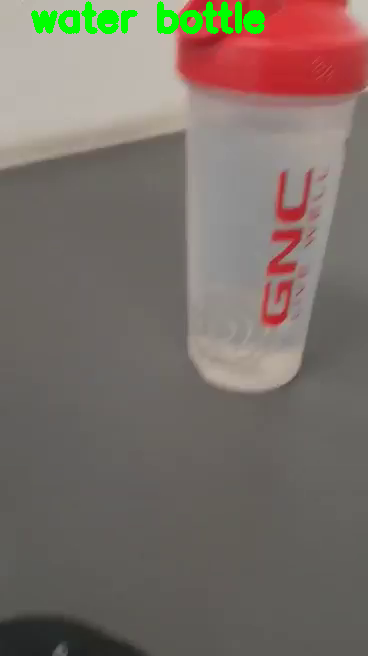

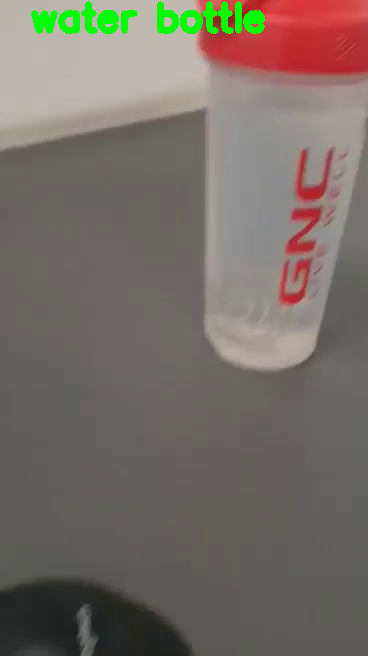

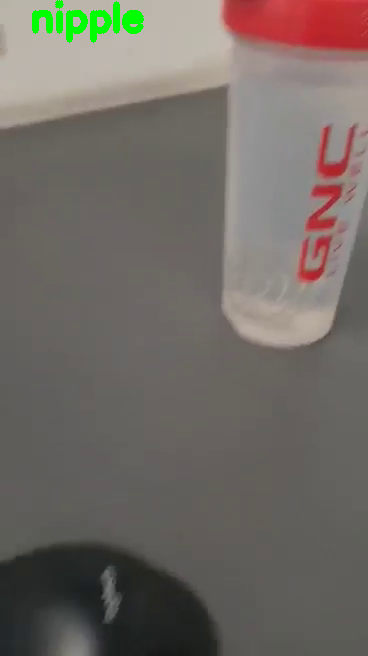

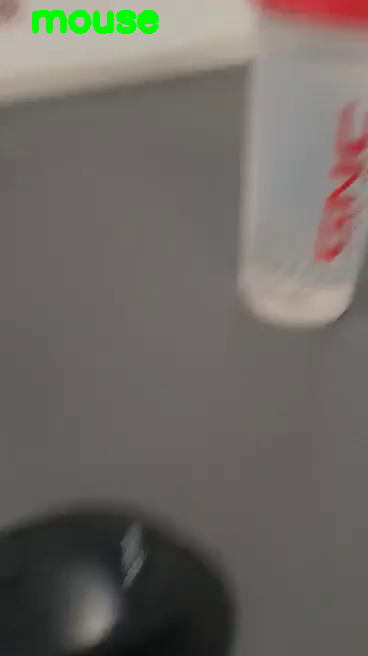

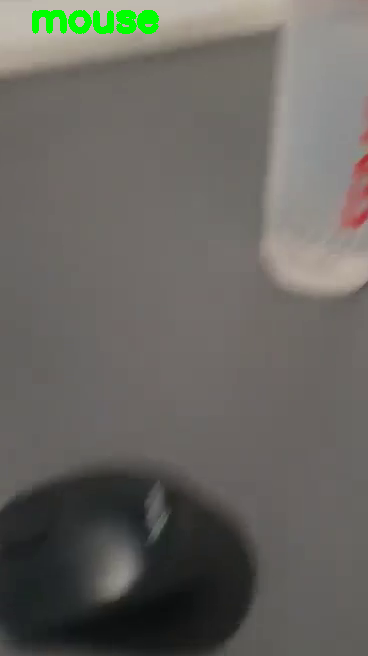

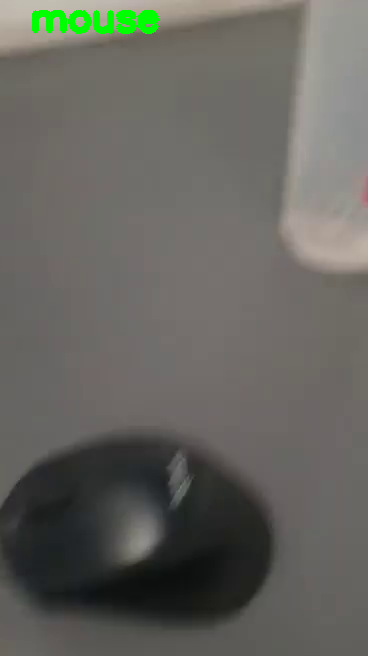

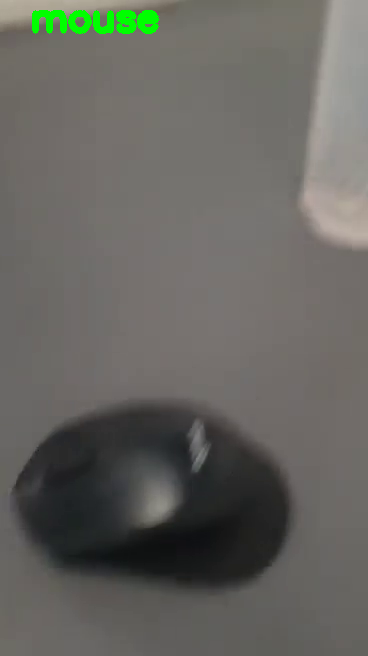

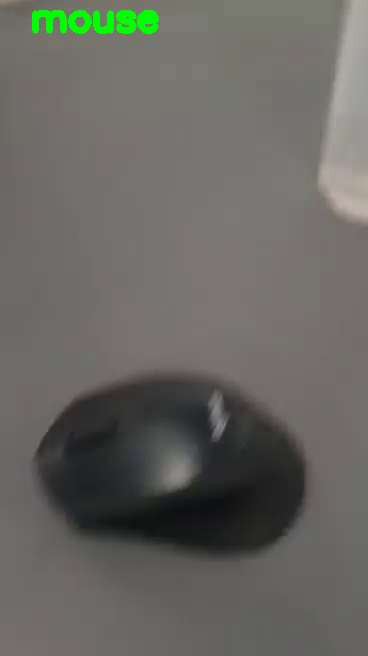

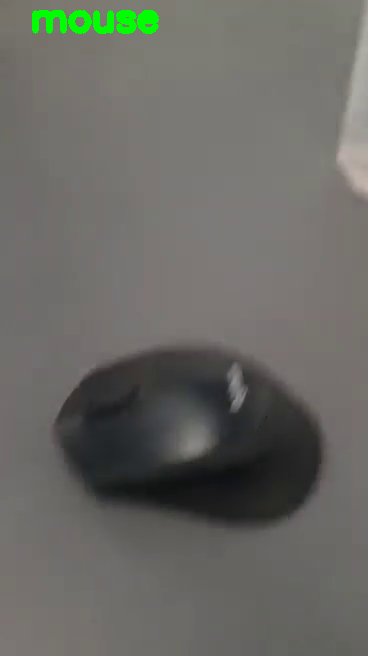

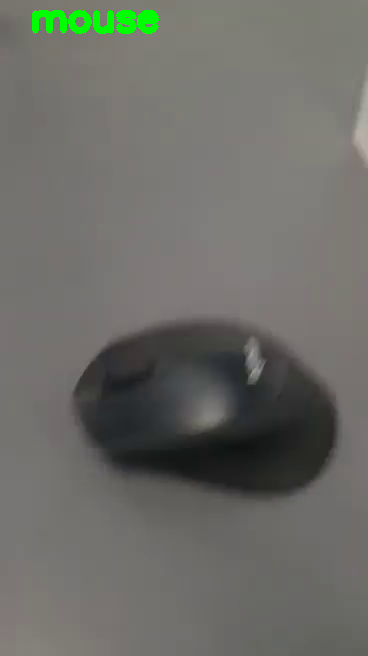

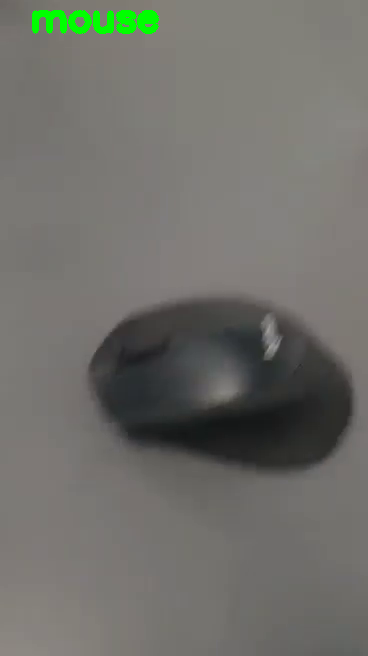

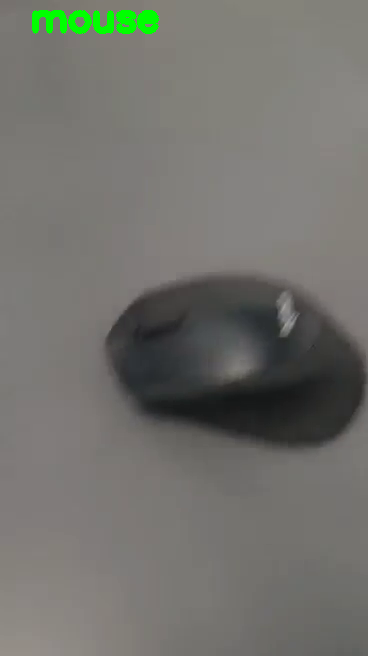

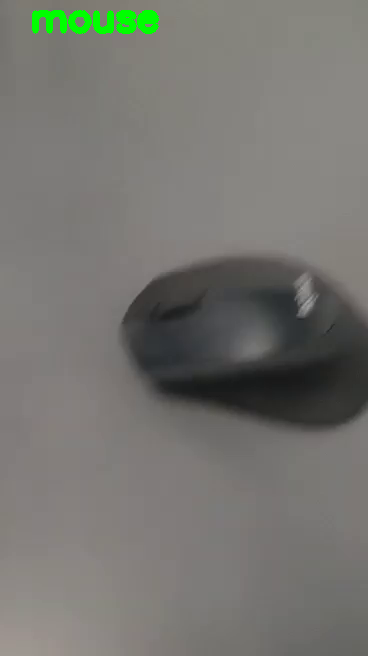

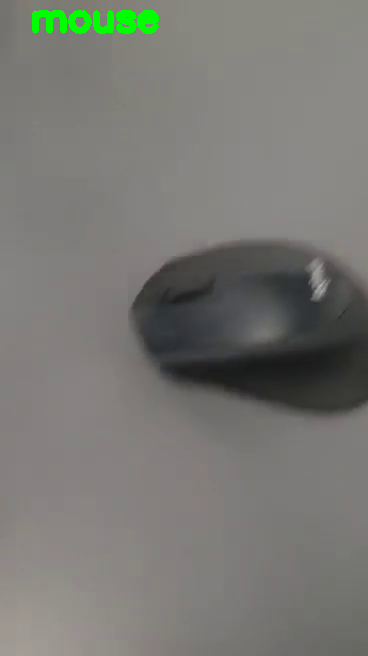

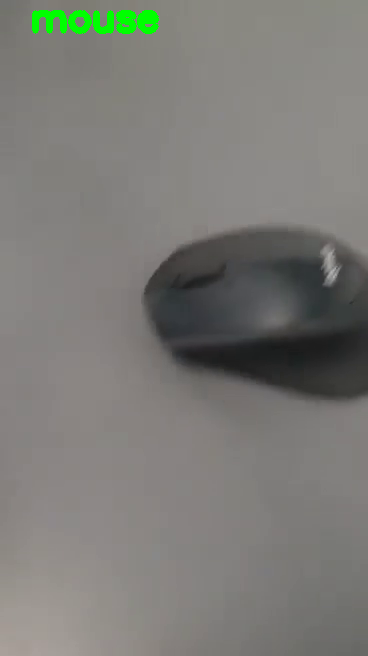

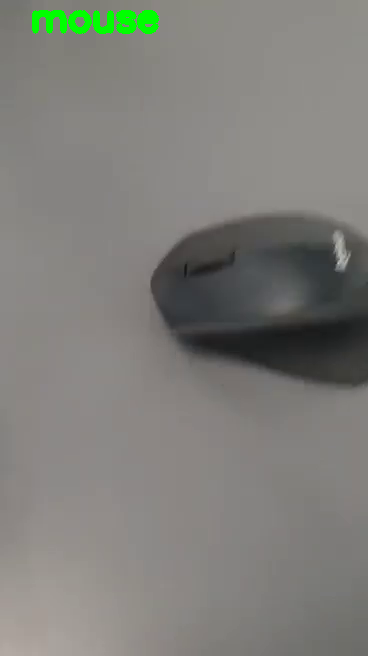

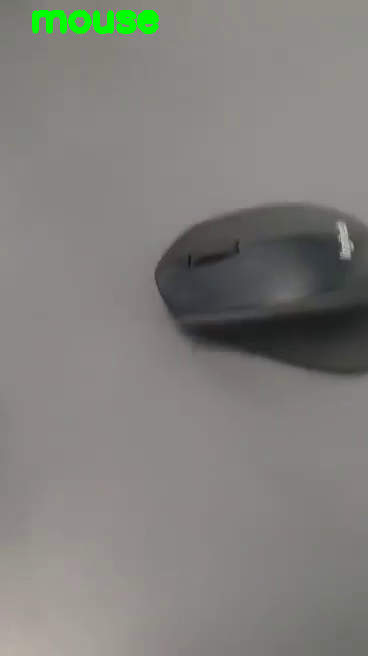

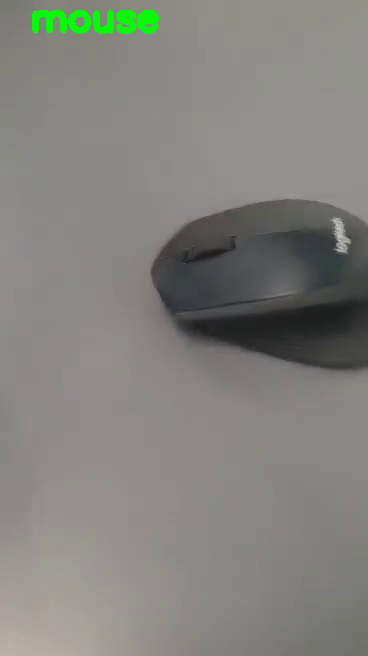

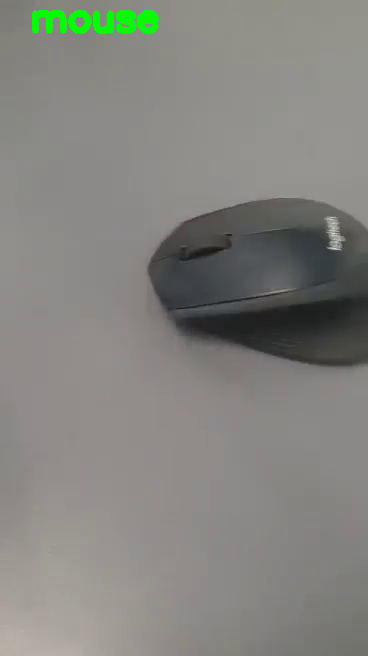

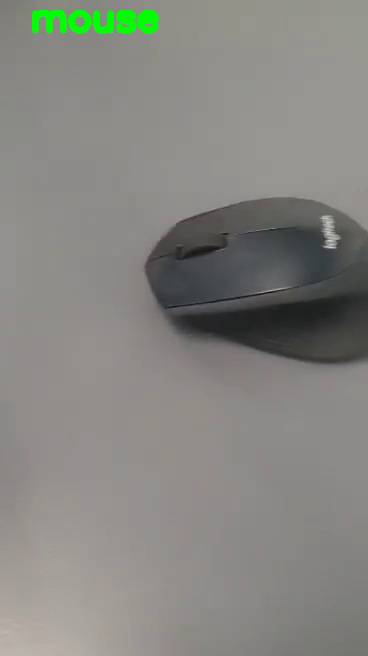

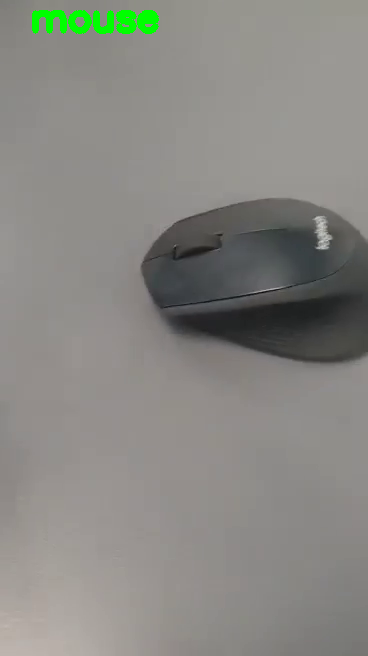

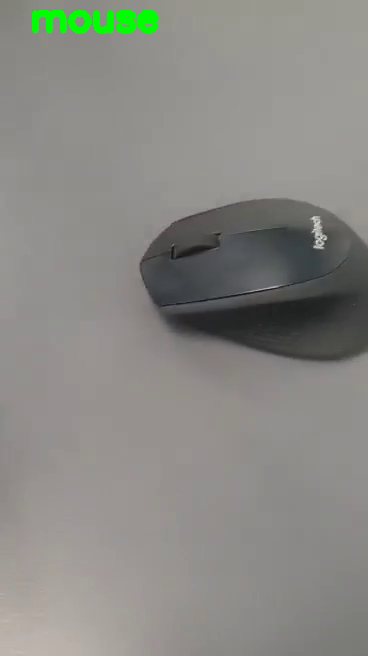

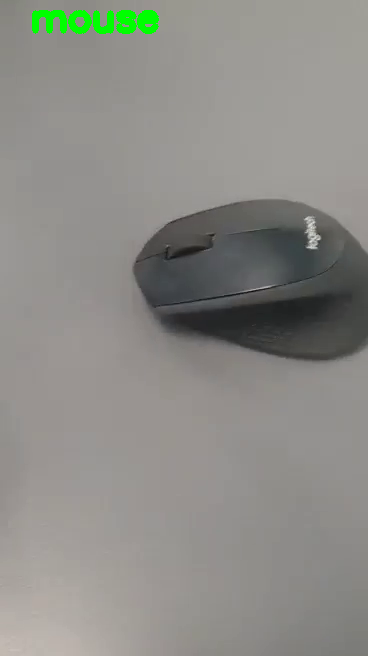

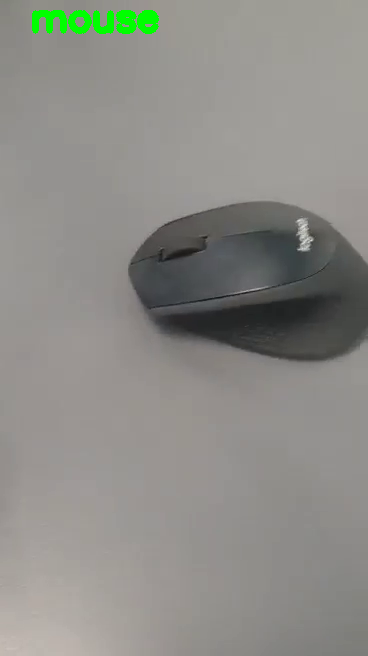

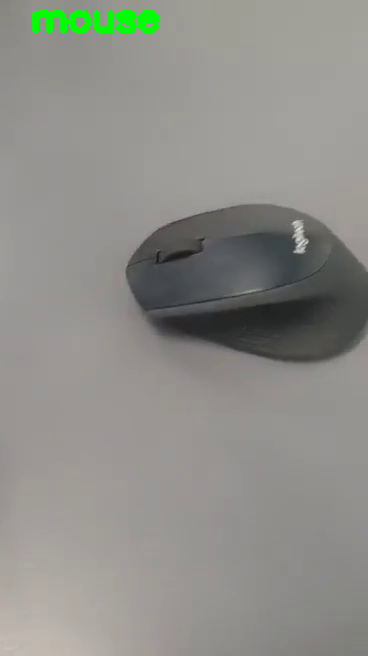

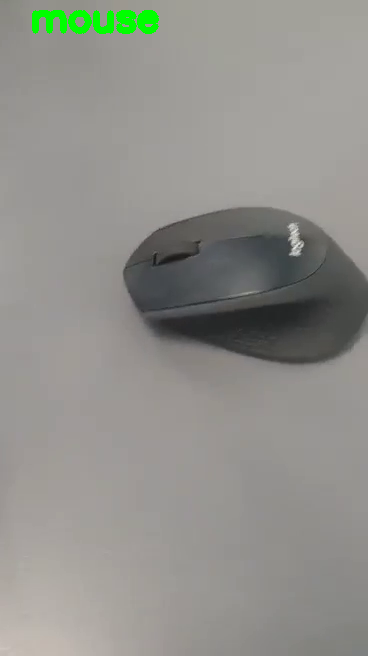

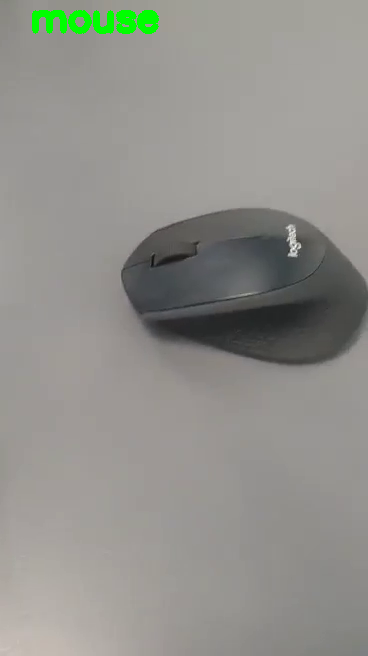

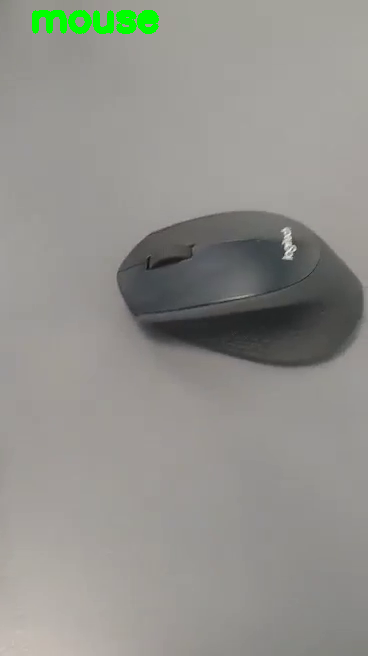

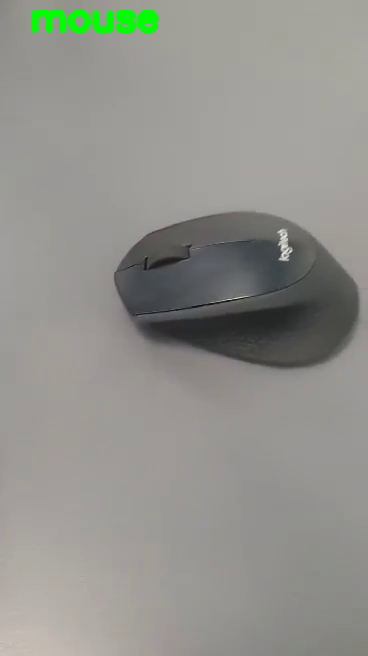

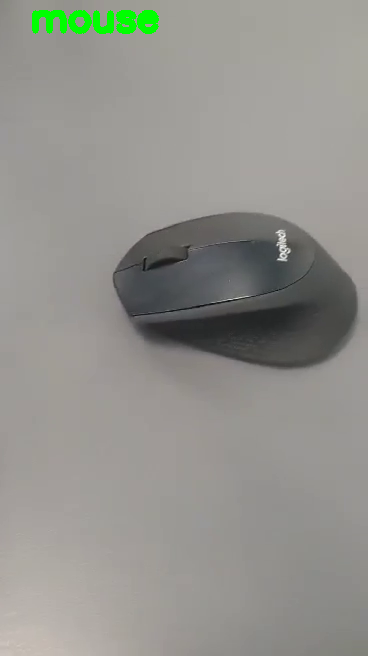

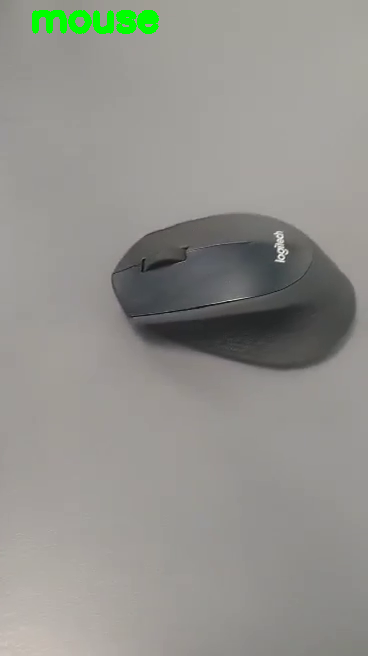

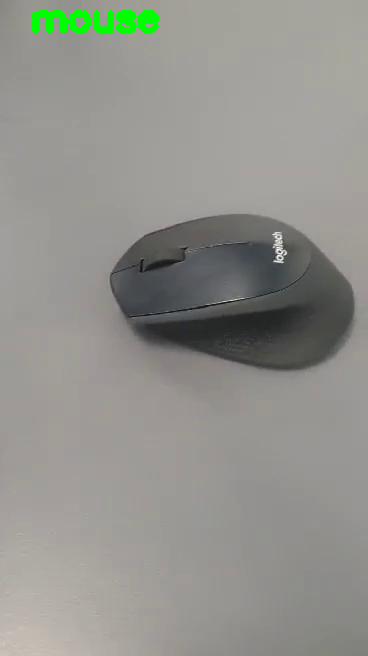

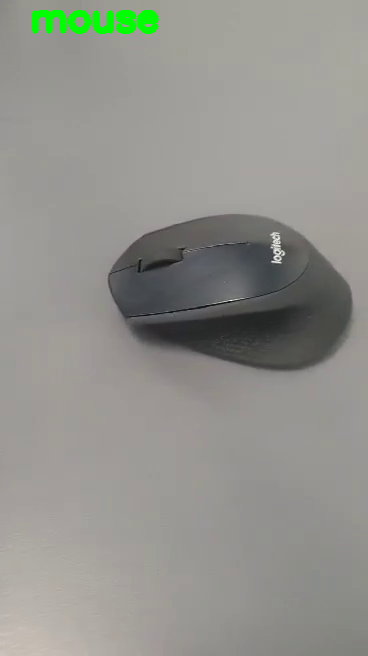

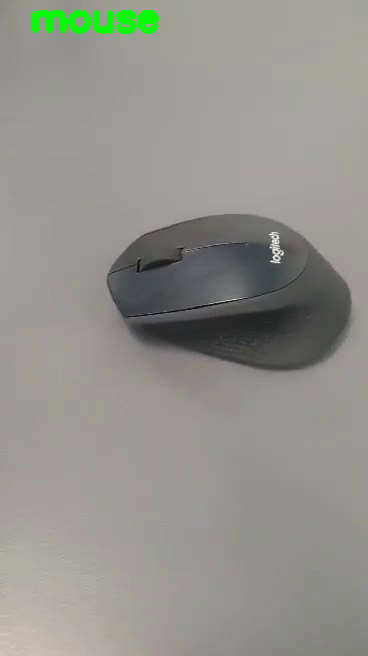

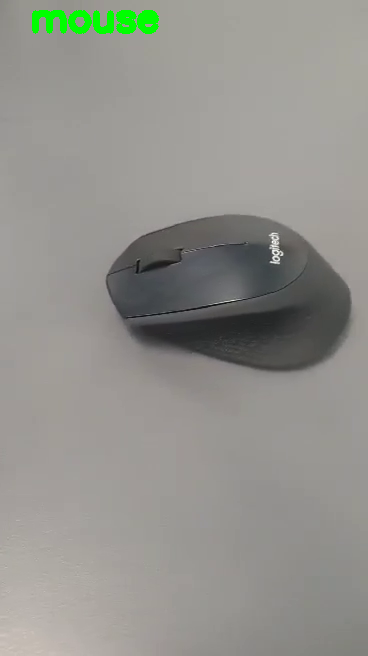

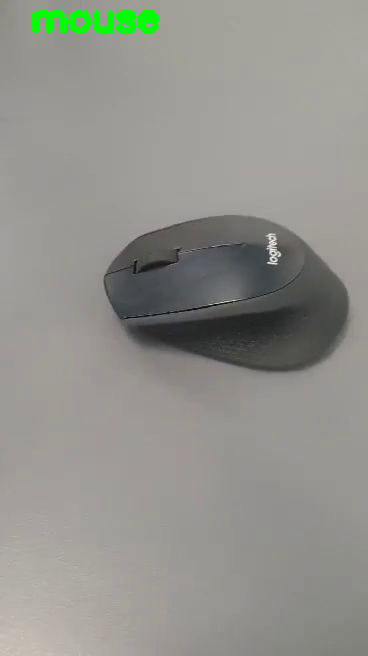

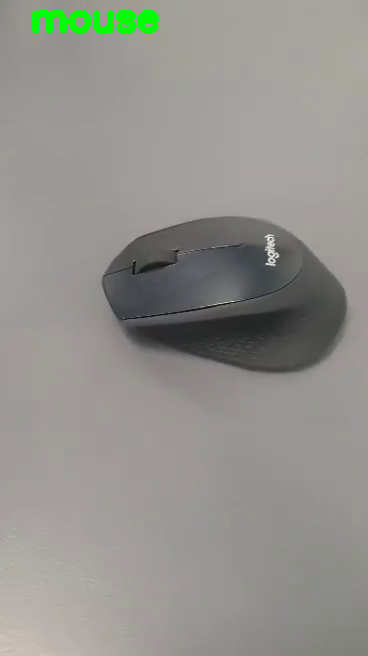

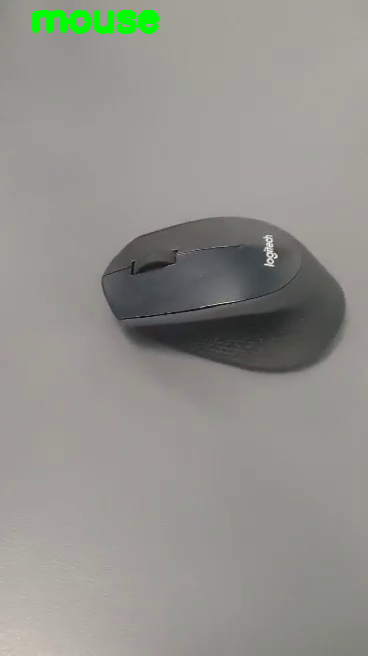

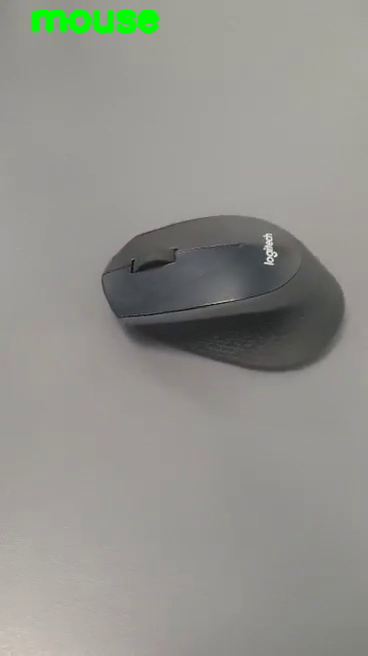

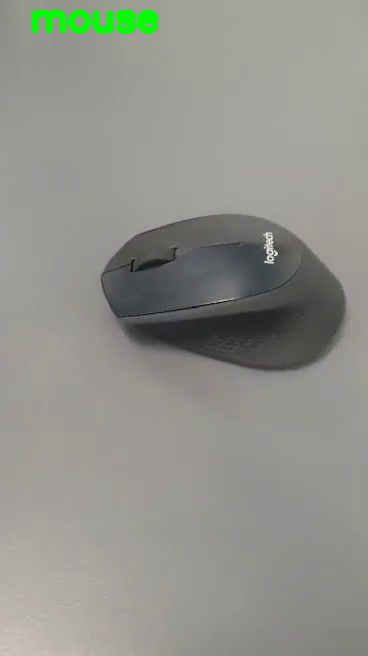

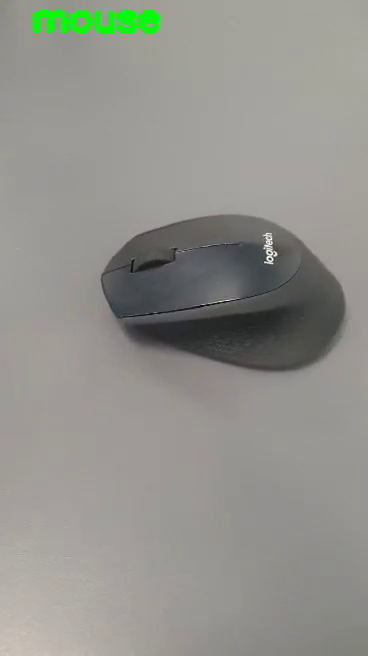

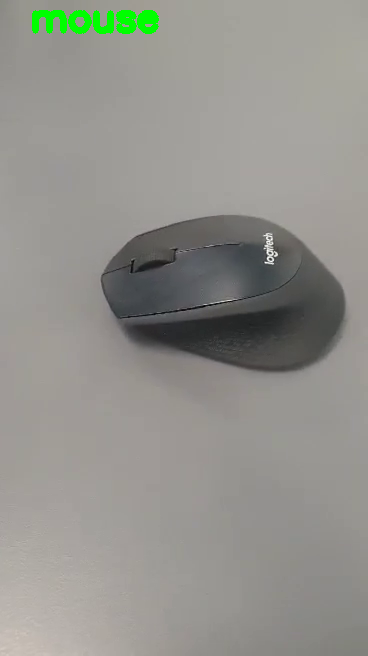

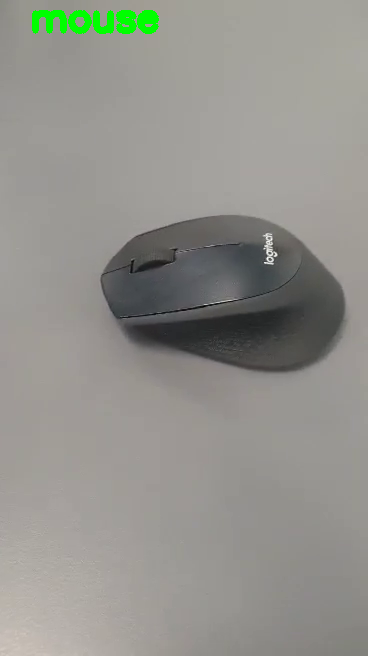

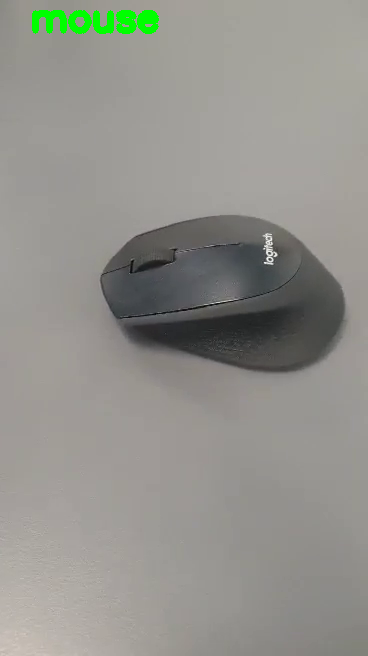

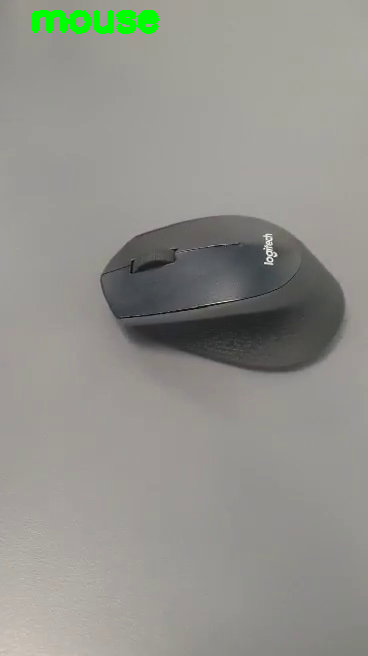

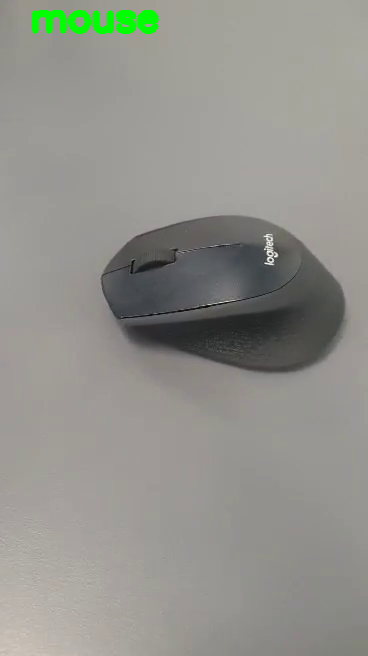

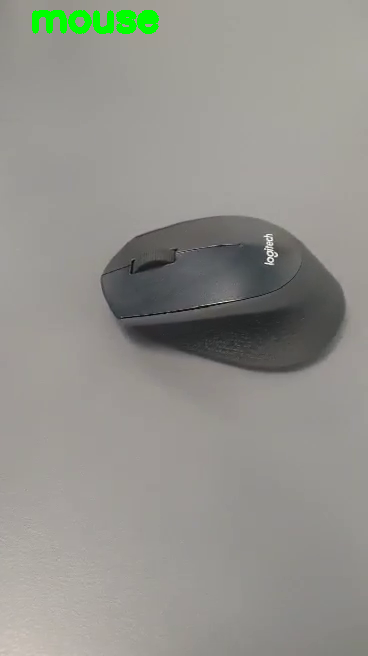

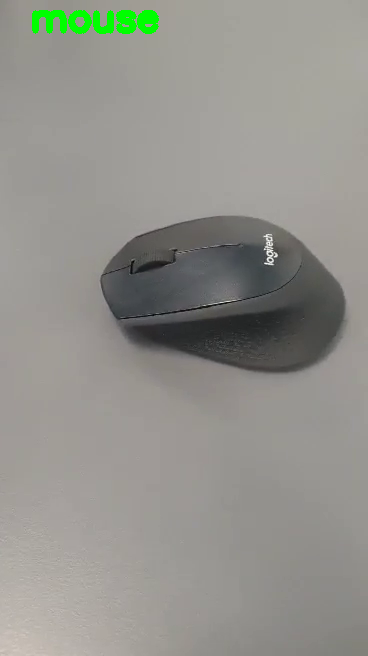

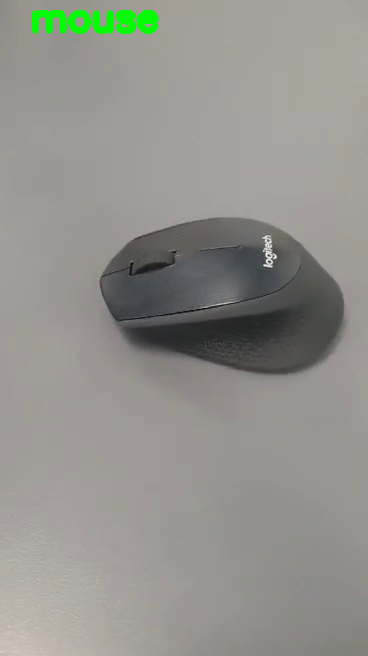

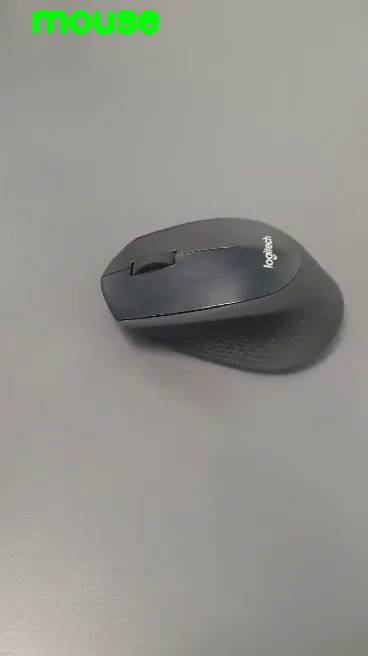

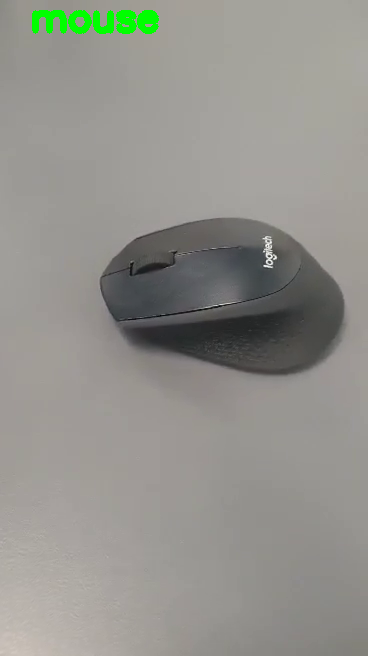

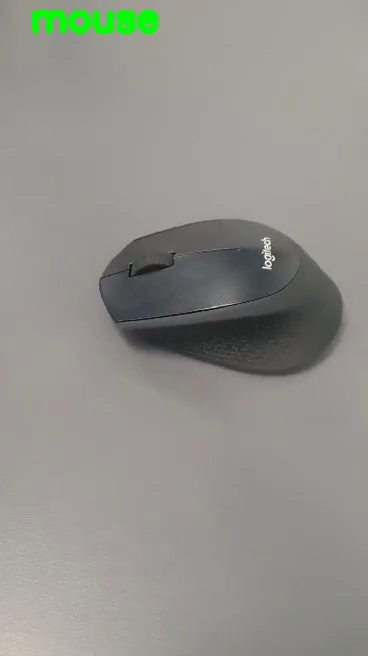

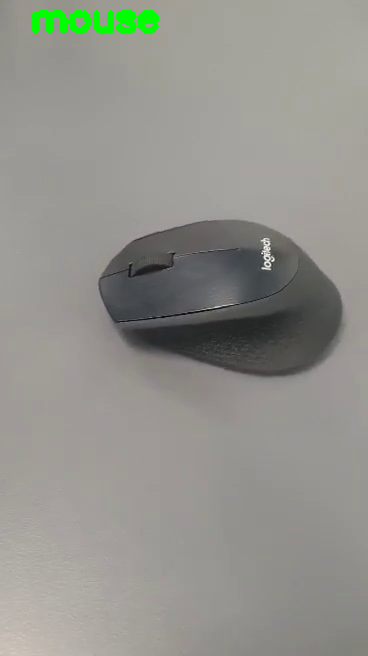

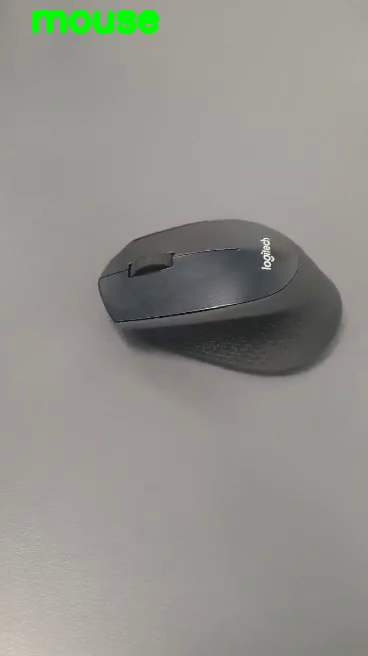

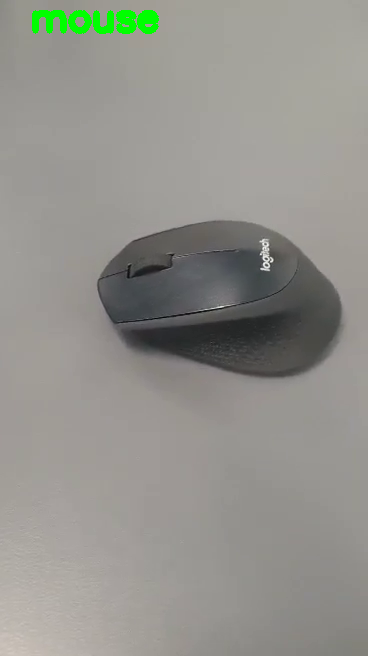

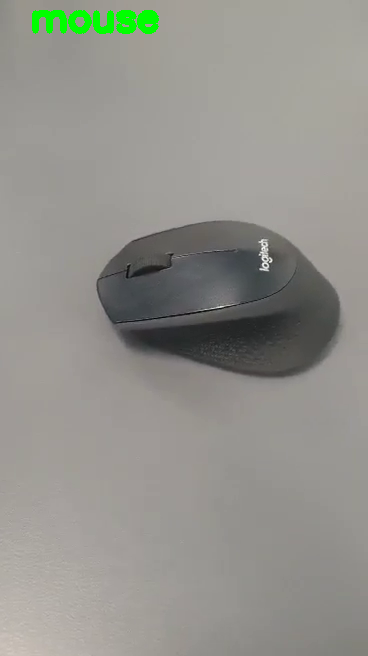

In [18]:
model_file = \
        data_path + "inception_v3_2016_08_28_frozen.pb"
label_file = data_path + "imagenet_slim_labels.txt"
input_height = 299
input_width = 299
input_mean = 0
input_std = 255
input_layer = "input"
output_layer = "InceptionV3/Predictions/Reshape_1"

#get input from the video as a sequence of images
cap = cv2.VideoCapture(data_path + "test_vid2.mp4")
while(cap.isOpened()):
    ret, frame = cap.read()
    if(ret == True):
        input = frame.copy()
        height, width, channels = input.shape

        t = read_tensor_from_video_file(numpy_data=input)
        #define model & other operations

        graph = load_graph(model_file)
        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)

        with tf.compat.v1.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: t
            })
        results = np.squeeze(results)

        top_k = results.argsort()[-5:][::-1]
        labels = load_labels(label_file)

        output = labels[top_k[0]]

        cv2.putText(input, output , (30, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1.25, (0, 255, 0), 5)
        cv2_imshow(input)
        if cv2.waitKey(25) == ord('q'):
            break
    else:
        break